<a href="https://colab.research.google.com/github/SlavaBts/Distributions-of-distances-on-scRNA-embeddings/blob/main/k_NN_distances_on_sc_embeddings_ipynb%22%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Задача 8. Охарактеризуйте характеристическое распределение расстояний внутри разных типов клеток на разных эмбеддингах: на экспрессиях (только на высоко вариабельных генах, отшкалированных и лог-трансформированных), на PCA, на UMAP, и на Palantir.

# Загрузка и просмотр данных

In [ ]:
# Загружаем данные

!pip install scanpy[leiden]
!gdown "1jW548g6ERFS0t7NywgyjRs6VaE5QwXbg&confirm=T"

In [2]:
# Загружаем библиотеки

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import scanpy as sc
import scanpy.external as sce

sns.set_style("ticks")
sc.settings.verbosity = 3
sc.set_figure_params(dpi=150)

In [3]:
# Прочитываем данные

adata = sc.read_h5ad("PBMC_Satija.h5ad")
adata.var_names_make_unique()

In [4]:
# Посмотрим, какие доноры есть
print(adata.obs['donor'].unique())
print(adata.obs.groupby('donor').size())

['P3', 'P1', 'P2']
Categories (3, object): ['P1', 'P2', 'P3']
donor
P1    6443
P2    5714
P3    5002
dtype: int64


<ipython-input-4-b8e5f4e2eec8>:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(adata.obs.groupby('donor').size())


In [5]:
# Посмотрим, какие клеточные типы присутствуют
print(adata.obs['celltype.l1'].unique())

['CD8 T', 'CD4 T', 'B', 'NK', 'other T', 'Mono', 'DC', 'other']
Categories (8, object): ['B', 'CD4 T', 'CD8 T', 'DC', 'Mono', 'NK', 'other', 'other T']


In [6]:
# Отбираем конкретного донора
adata_P1 = adata[adata.obs['donor'] == 'P1'].copy()
print(adata_P1.obs['donor'].unique())
print(adata_P1.obs['donor'].count())

['P1']
Categories (1, object): ['P1']
6443


In [ ]:
# Проверим еще раз во избежание невроза
adata_P1.X

# QC

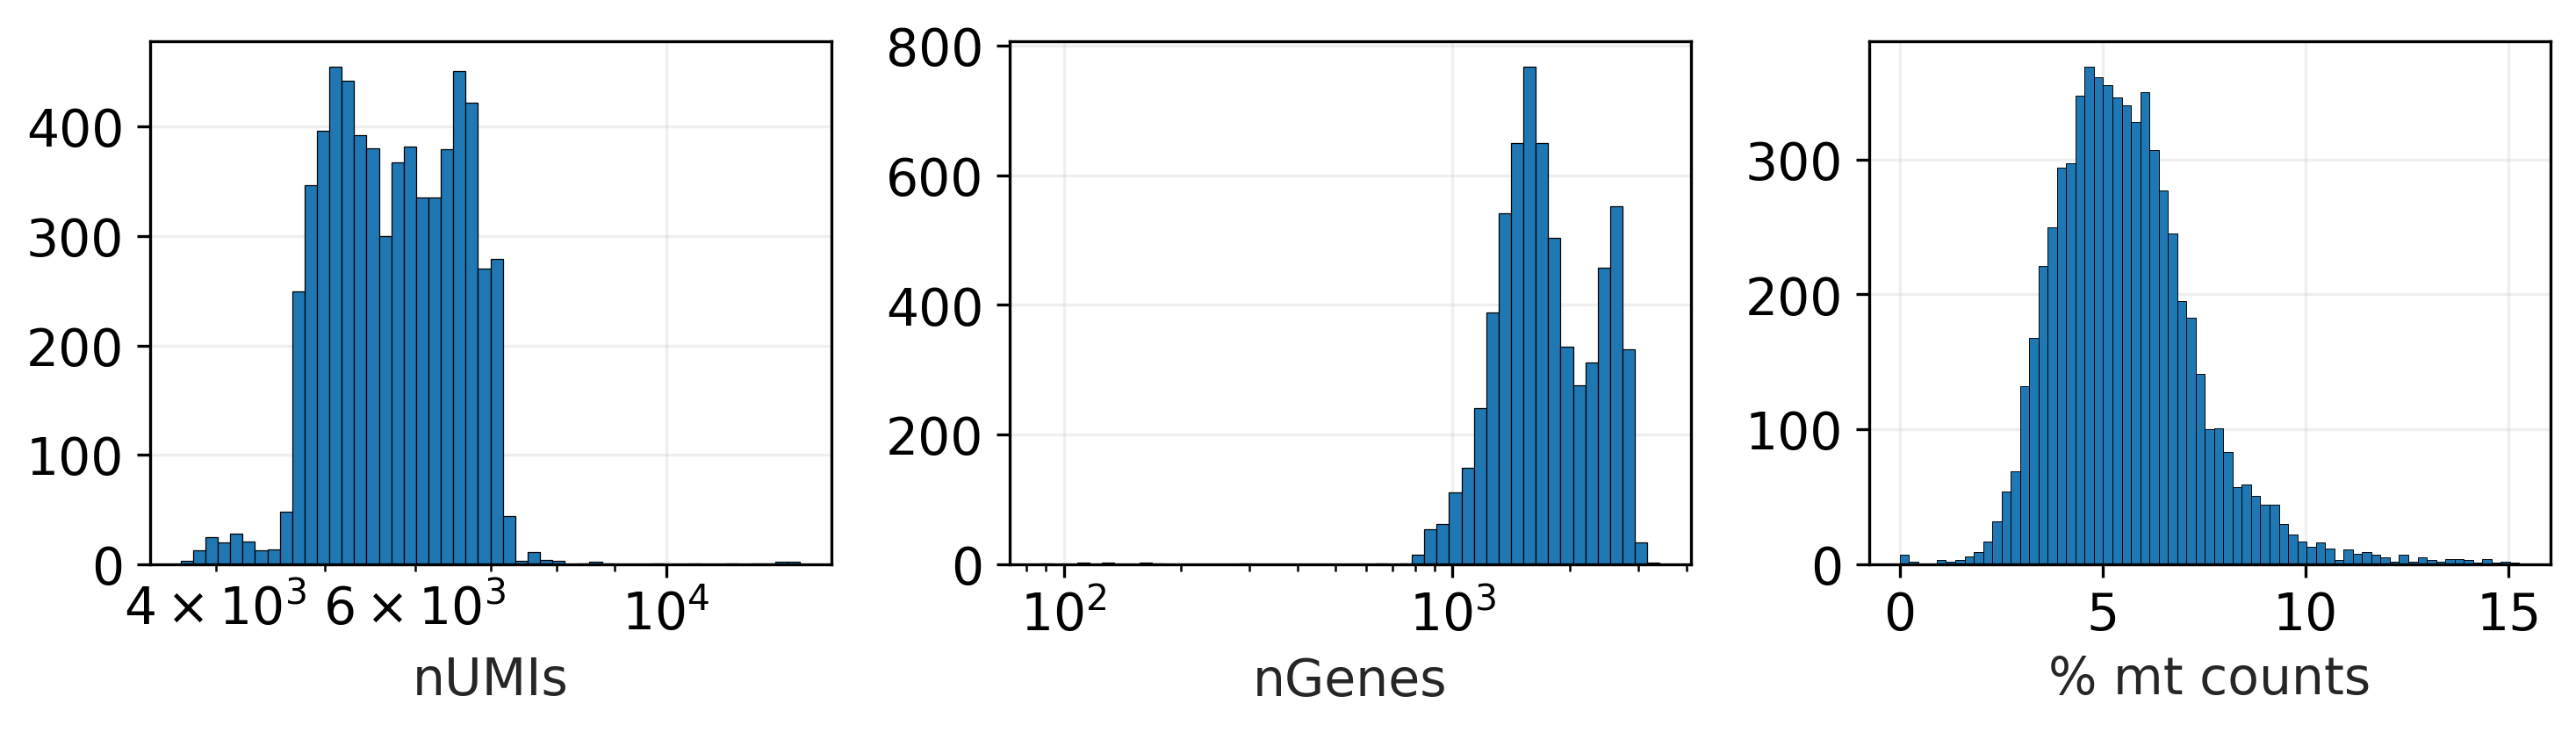

In [8]:
# Смотрим метрики QC для конкретного донора

adata_P1.var["mt"] = adata_P1.var.index.str.startswith("MT-")
sc.pp.calculate_qc_metrics(
    adata_P1,
    qc_vars=["mt"],
    percent_top=None,
    inplace=True,
    log1p=False,
)

fig, axes = plt.subplots(ncols=3, figsize=(10, 3))

sns.histplot(adata_P1.obs.total_counts, log_scale=True, alpha=1, bins=50, edgecolor="black", ax=axes[0])
axes[0].set_ylabel("")
axes[0].set_xlabel("nUMIs")
axes[0].grid(alpha=0.3)

sns.histplot(adata_P1.obs.n_genes_by_counts, log_scale=True, alpha=1, bins=50, edgecolor="black", ax=axes[1])
axes[1].set_ylabel("")
axes[1].set_xlabel("nGenes")
axes[1].grid(alpha=0.3)

sns.histplot(adata_P1.obs.pct_counts_mt, alpha=1, edgecolor="black", ax=axes[2])
axes[2].set_ylabel("")
axes[2].set_xlabel("% mt counts")
axes[2].grid(alpha=0.3)

fig.tight_layout()

In [9]:
print(adata_P1)

AnnData object with n_obs × n_vars = 6443 × 20729
    obs: 'orig.ident', 'lane', 'donor', 'time', 'celltype.l1', 'celltype.l2', 'celltype.l3', 'Phase', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'


# Процессинг

In [ ]:
# Маркируем и удаляем дублеты

sc.pp.scrublet(adata_P1)
adata_P1 = adata_P1[adata_P1.obs.doublet_score <= 0.2].copy()

In [11]:
# Антиневроз
print(adata_P1)

AnnData object with n_obs × n_vars = 6392 × 20729
    obs: 'orig.ident', 'lane', 'donor', 'time', 'celltype.l1', 'celltype.l2', 'celltype.l3', 'Phase', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'doublet_score', 'predicted_doublet'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'scrublet'


In [ ]:
# Нормализуем данные. Начиная с этой ячейки adata_P1 содержит нормированныe HVG

sc.pp.normalize_total(adata_P1, target_sum=1e4)
sc.pp.log1p(adata_P1)
sc.pp.highly_variable_genes(adata_P1, n_top_genes=3000)

adata_P1_raw = adata_P1.copy()

adata_P1 = adata_P1[:, adata_P1.var.highly_variable]

# Шкалирование, PCA, UMAP и Palantir

In [ ]:
# Шкалирование
sc.pp.scale(adata_P1, max_value=10)

computing PCA
    with n_comps=30
    finished (0:00:02)


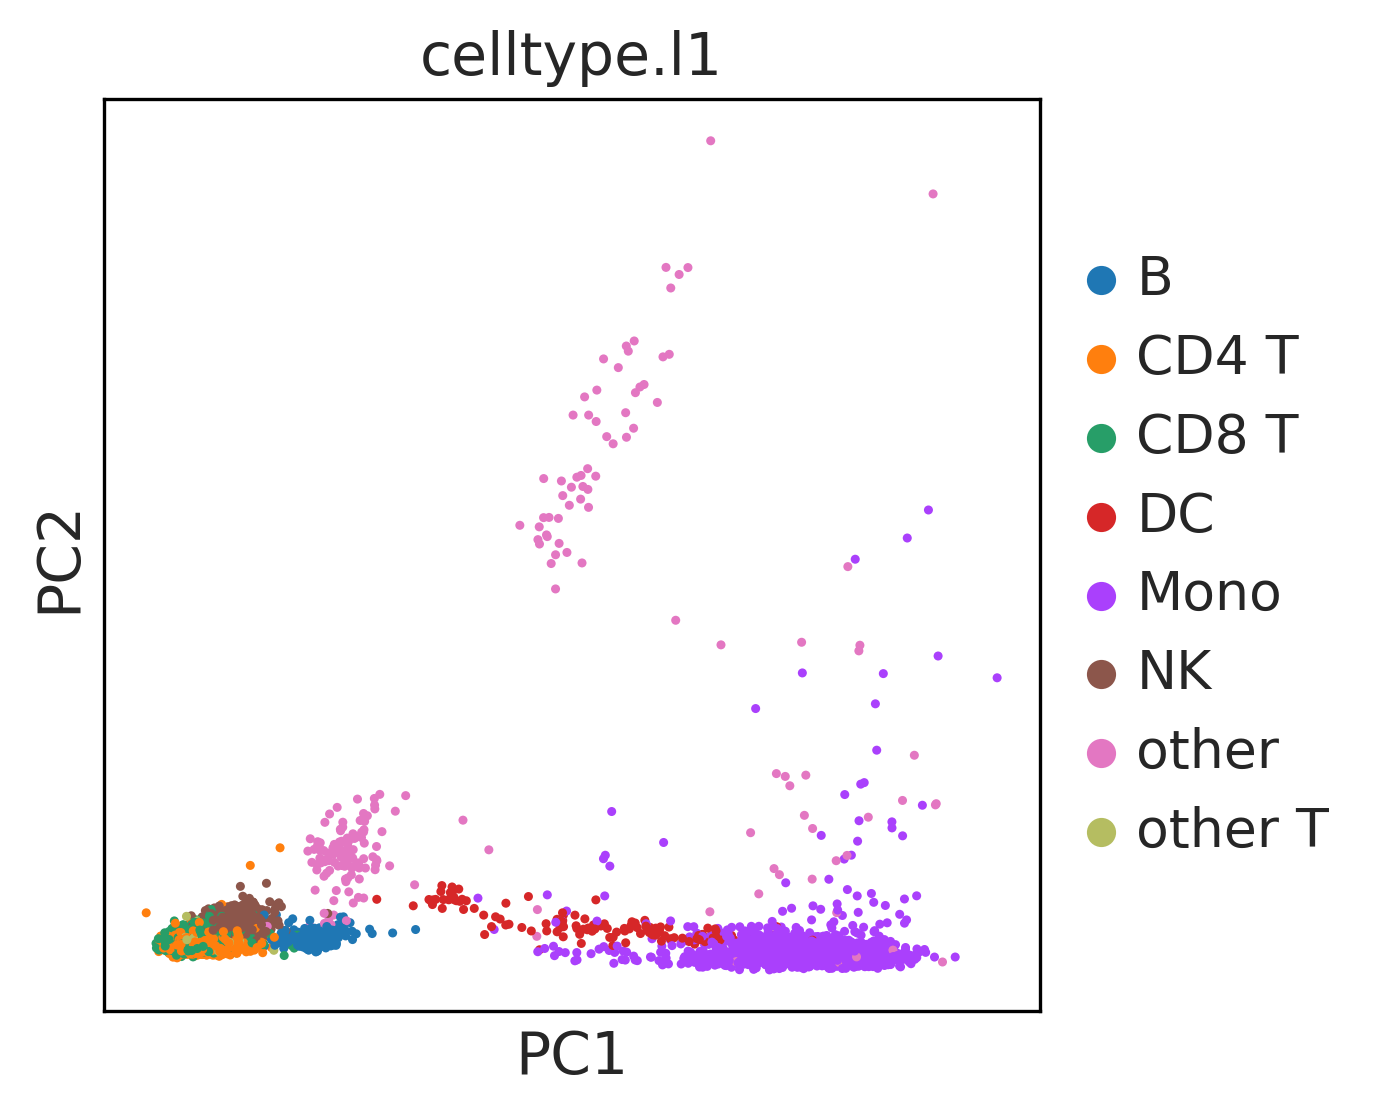

In [14]:
# PCA
sc.pp.pca(adata_P1, n_comps=30)
sc.pl.pca(adata_P1, color='celltype.l1')  # Визуализация PCA

computing neighbors
    using 'X_pca' with n_pcs = 30
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:13)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:16)


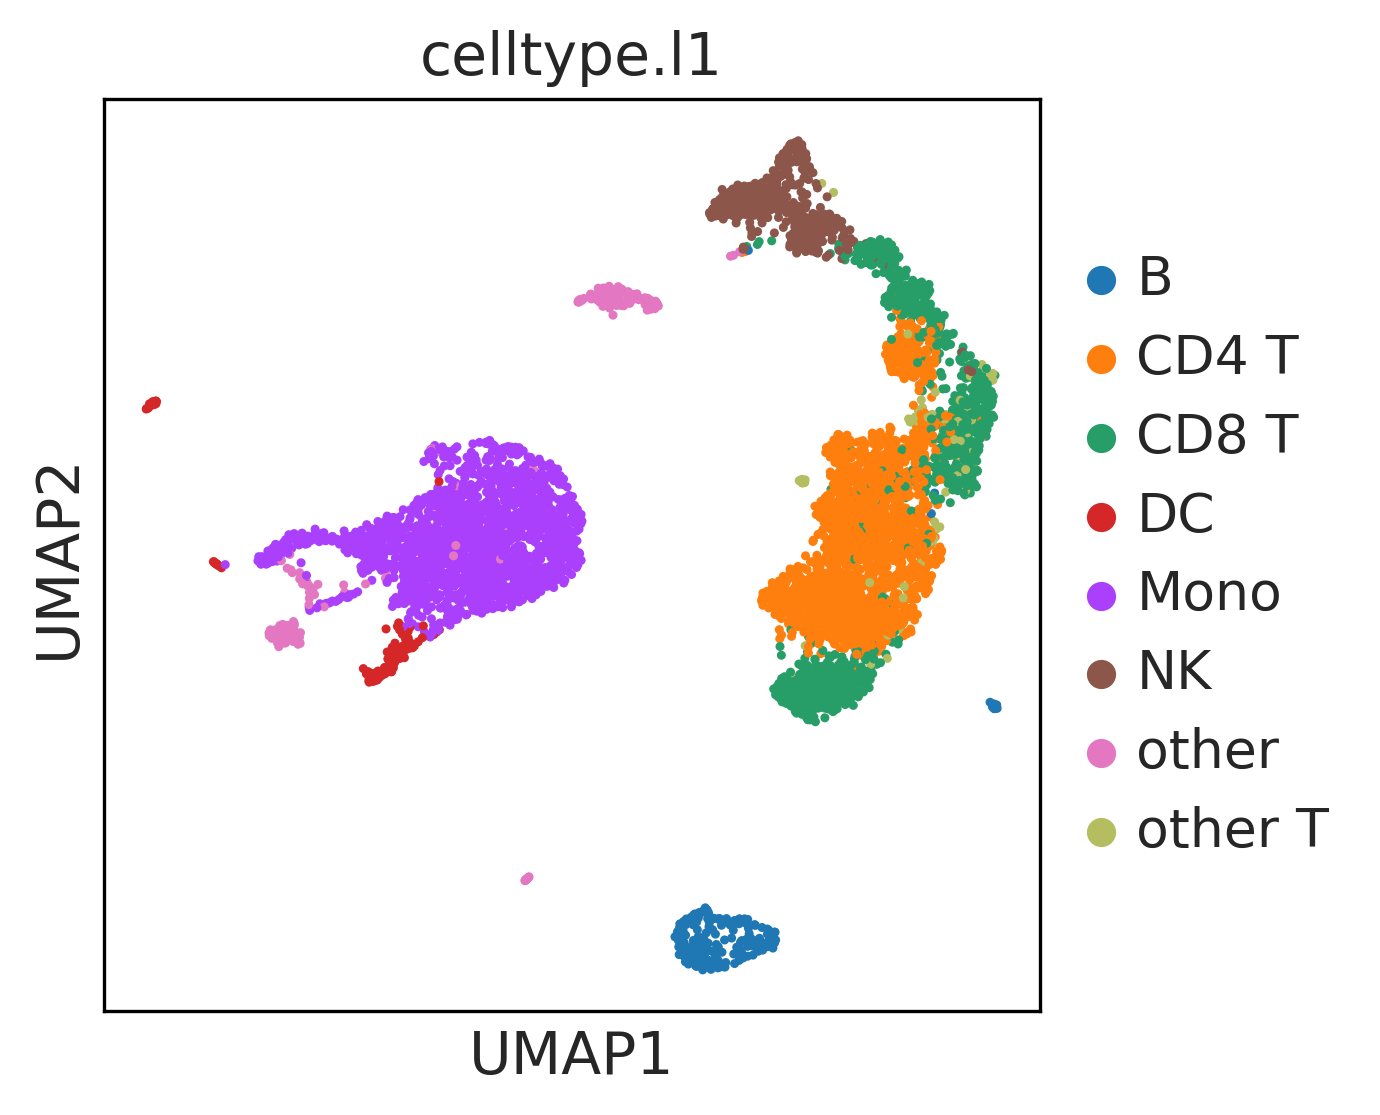

In [15]:
# UMAP
sc.pp.neighbors(adata_P1)  # Строим граф k-NN
sc.tl.umap(adata_P1)       # UMAP
sc.pl.umap(adata_P1, color='celltype.l1')  # Визуализация UMAP

In [ ]:
# Устанавливаем Palantir
!pip install palantir
import palantir

In [ ]:
# 1. Извлечение PCA-координат из adata
pca_projections = pd.DataFrame(adata_P1.obsm["X_pca"], index=adata_P1.obs_names)

# 2. Построение диффузионных карт с помощью Palantir
# dm_res содержит собственные векторы и собственные значения диффузионных карт
dm_res = palantir.utils.run_diffusion_maps(pca_projections)

# 3. Определение многомасштабного пространства (multiscale space)
# Мы выбираем первые n_eigs собственных векторов для представления
ms_data = palantir.utils.determine_multiscale_space(dm_res, n_eigs=4)

# 4. Сохранение результатов Palantir в obsm объекта AnnData
# Преобразуем ms_data в формат NumPy и добавляем его в AnnData
adata_P1.obsm["X_palantir"] = ms_data.values

# Расстояния до k-ближайших соседей

In [17]:
# Еще раз посмотрим на структуру данных
print(adata_P1)

AnnData object with n_obs × n_vars = 6392 × 3000
    obs: 'orig.ident', 'lane', 'donor', 'time', 'celltype.l1', 'celltype.l2', 'celltype.l3', 'Phase', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'doublet_score', 'predicted_doublet'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'scrublet', 'log1p', 'hvg', 'pca', 'celltype.l1_colors', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'


In [21]:
# Делаем копии исходного пространства данных
# Для того чтобы сохранить все метки точек при реализации sc.pp.neighbors
adata_P1_pca = adata_P1.copy()
adata_P1_umap = adata_P1.copy()
adata_P1_palantir = adata_P1.copy()

In [ ]:
# Получаем массив knn-distances для экспрессионного эмбеддинга
sc.pp.neighbors(adata_P1, use_rep="X")
distances_knn_exp = adata_P1.obsp["distances"].data

# Получаем массив knn-distances для PCA-эмбеддинга
sc.pp.neighbors(adata_P1_pca, use_rep="X_pca")
distances_knn_pca = adata_P1_pca.obsp["distances"].data

# Получаем массив knn-distances для UMAP-эмбеддинга
sc.pp.neighbors(adata_P1_umap, use_rep="X_umap")
distances_knn_umap = adata_P1_umap.obsp["distances"].data

# Получаем массив knn-distances для Palantir-эмбеддинга
sc.pp.neighbors(adata_P1_palantir, use_rep="X_palantir")
distances_knn_palantir = adata_P1_palantir.obsp["distances"].data

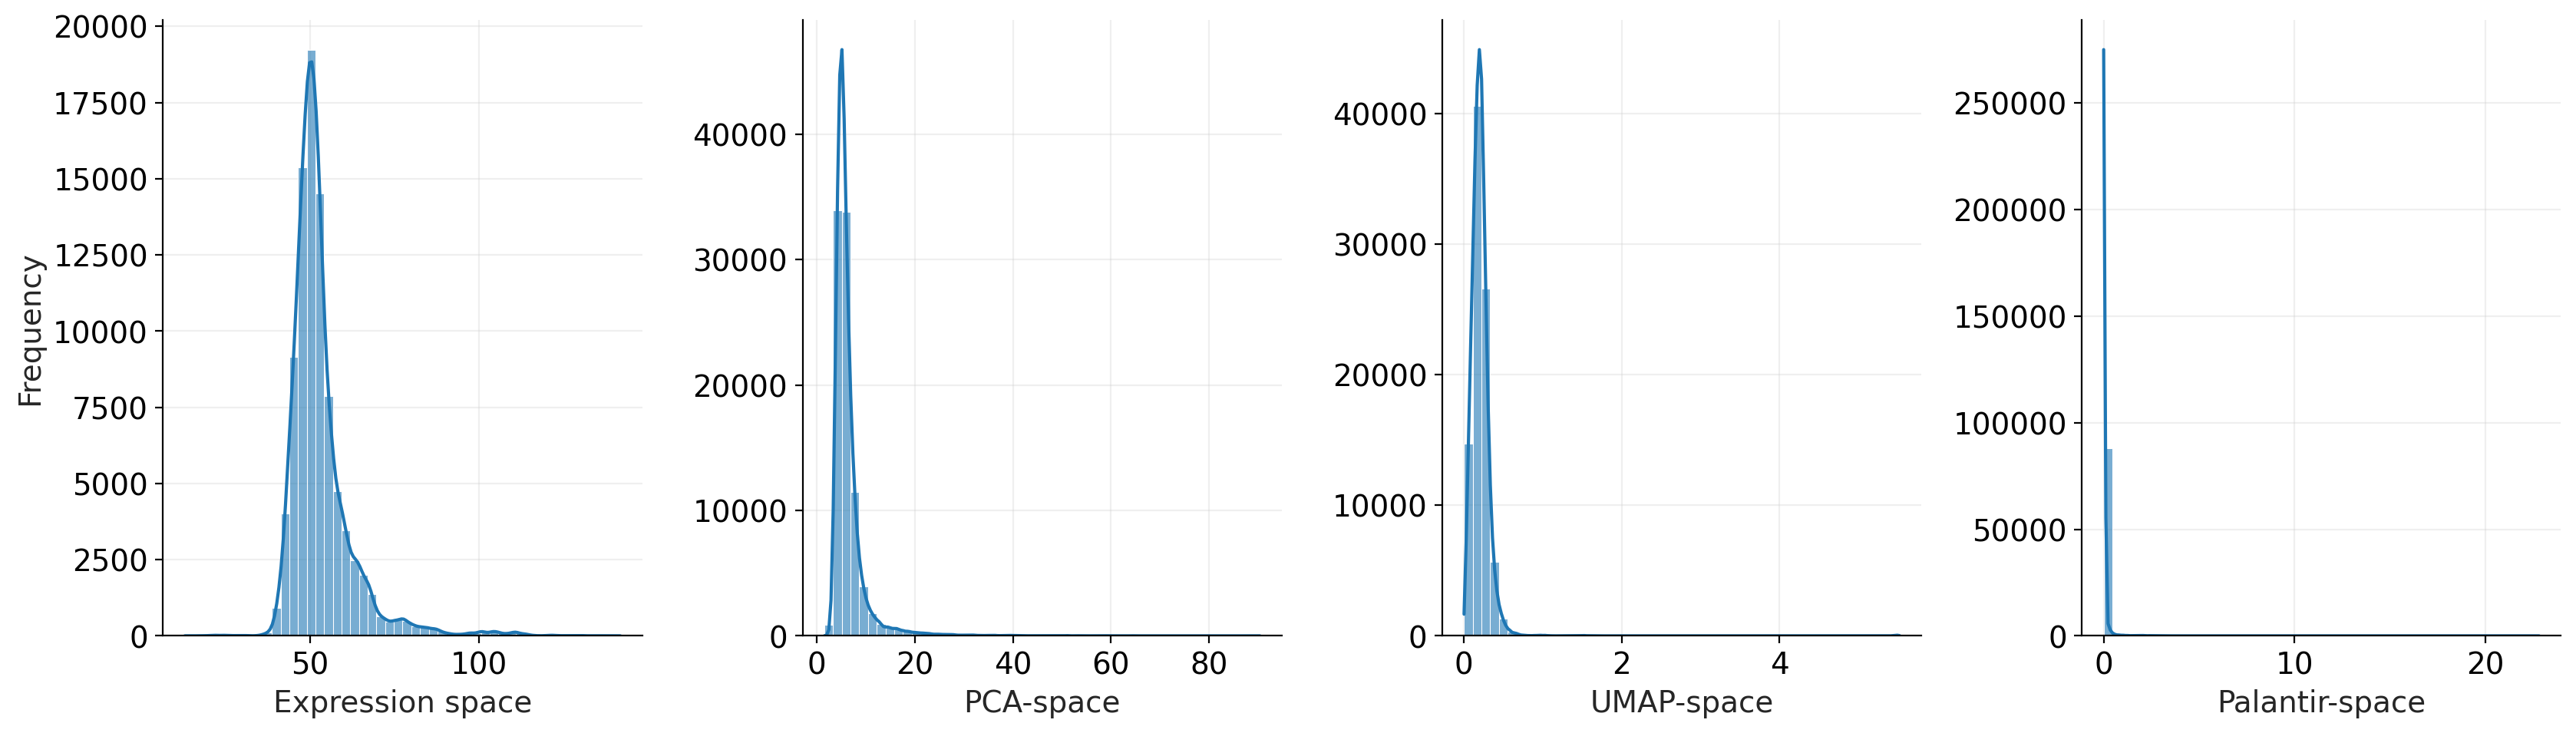

In [79]:
fig, axes = plt.subplots(ncols=4, figsize=(17, 5))

sns.histplot(distances_knn_exp, kde=True, bins=50, alpha=0.6, ax=axes[0])
axes[0].set_ylabel("Frequency")
axes[0].set_xlabel("Expression space")
axes[0].grid(alpha=0.3)

sns.histplot(distances_knn_pca, kde=True, bins=50, alpha=0.6, ax=axes[1])
axes[1].set_ylabel("")
axes[1].set_xlabel("PCA-space")
axes[1].grid(alpha=0.3)

sns.histplot(distances_knn_umap, kde=True, bins=50, alpha=0.6, ax=axes[2])
axes[2].set_ylabel("")
axes[2].set_xlabel("UMAP-space")
axes[2].grid(alpha=0.3)

sns.histplot(distances_knn_palantir, kde=True, bins=50, alpha=0.6, ax=axes[3])
axes[3].set_ylabel("")
axes[3].set_xlabel("Palantir-space")
axes[3].grid(alpha=0.3)

fig.tight_layout()

# kNN-расстояния внутри клеточных типов

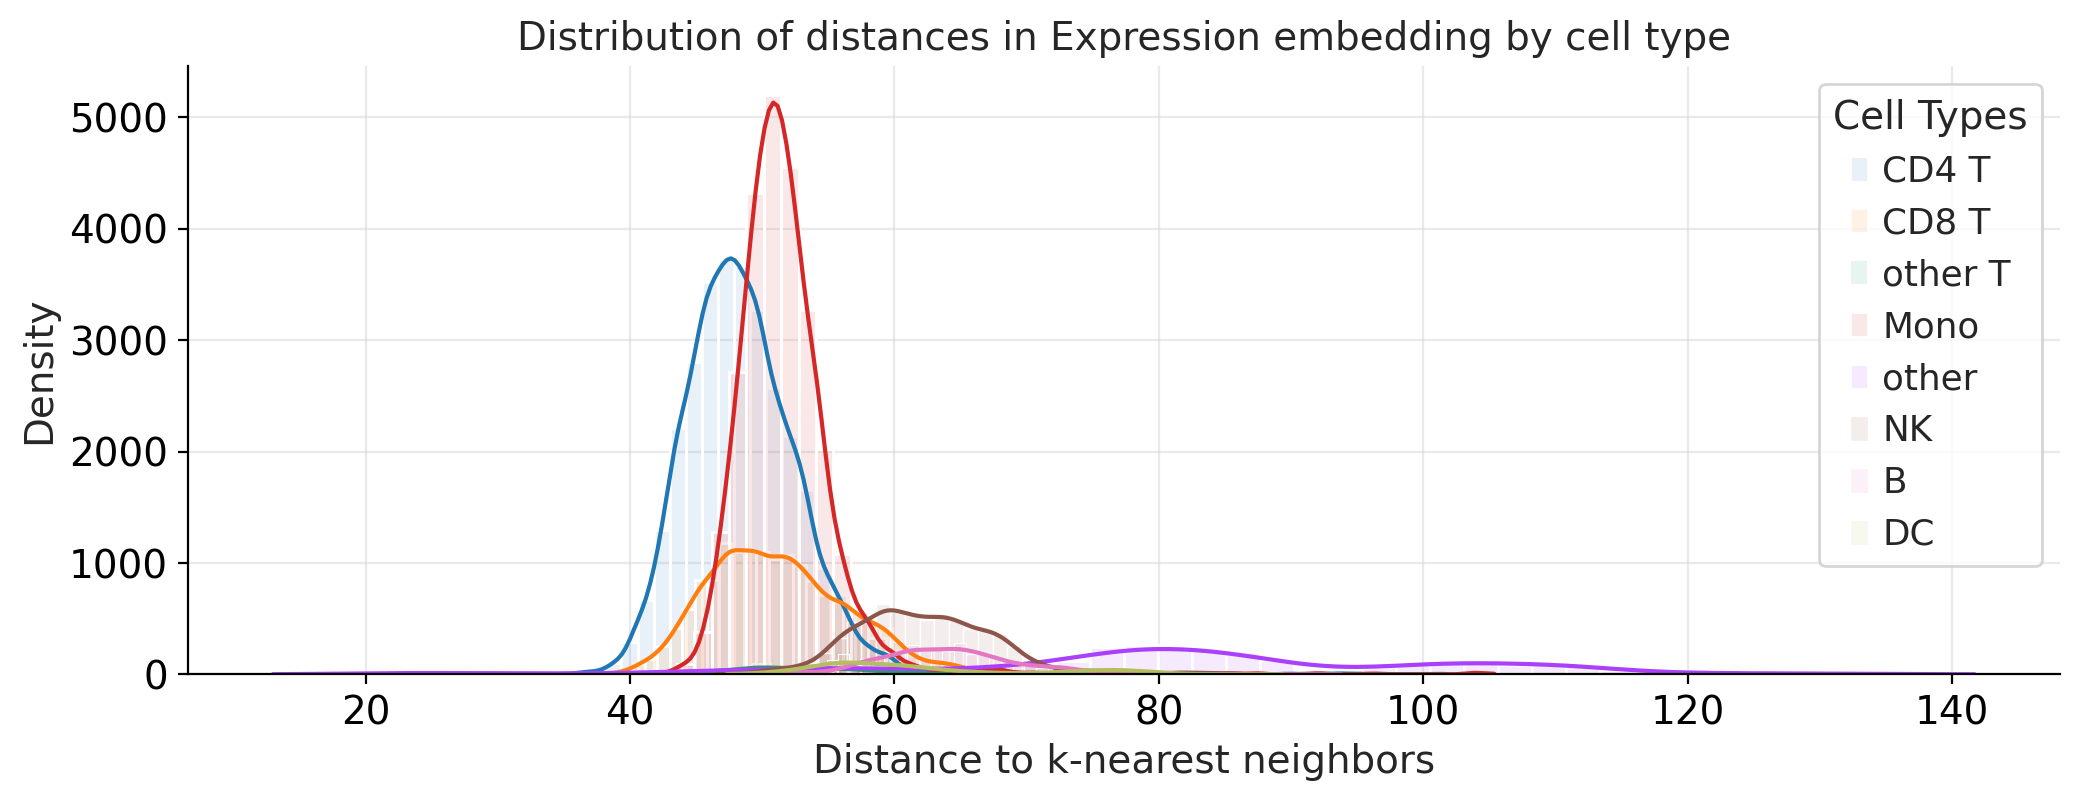

In [75]:
# Доступ к матрице расстояний и клеточным типам
distances_exp = adata_P1.obsp["distances"]
cell_types = adata_P1.obs['celltype.l1'].unique()

# Визуализация распределений расстояний для PCA-эмбеддинга
plt.figure(figsize=(12, 4))
for cell_type in cell_types:
    # Маска для отбора клеток данного типа
    cell_mask = adata_P1.obs['celltype.l1'] == cell_type
    # Извлечение расстояний для клеток данного типа
    cell_distances = distances_exp[cell_mask].data

    sns.histplot(cell_distances, label=cell_type, kde=True, bins=50, alpha=0.1)

# Настройки графика
plt.legend(title="Cell Types")
plt.xlabel("Distance to k-nearest neighbors")
plt.ylabel("Density")
plt.title("Distribution of distances in Expression embedding by cell type")
plt.grid(alpha=0.4)
plt.show()

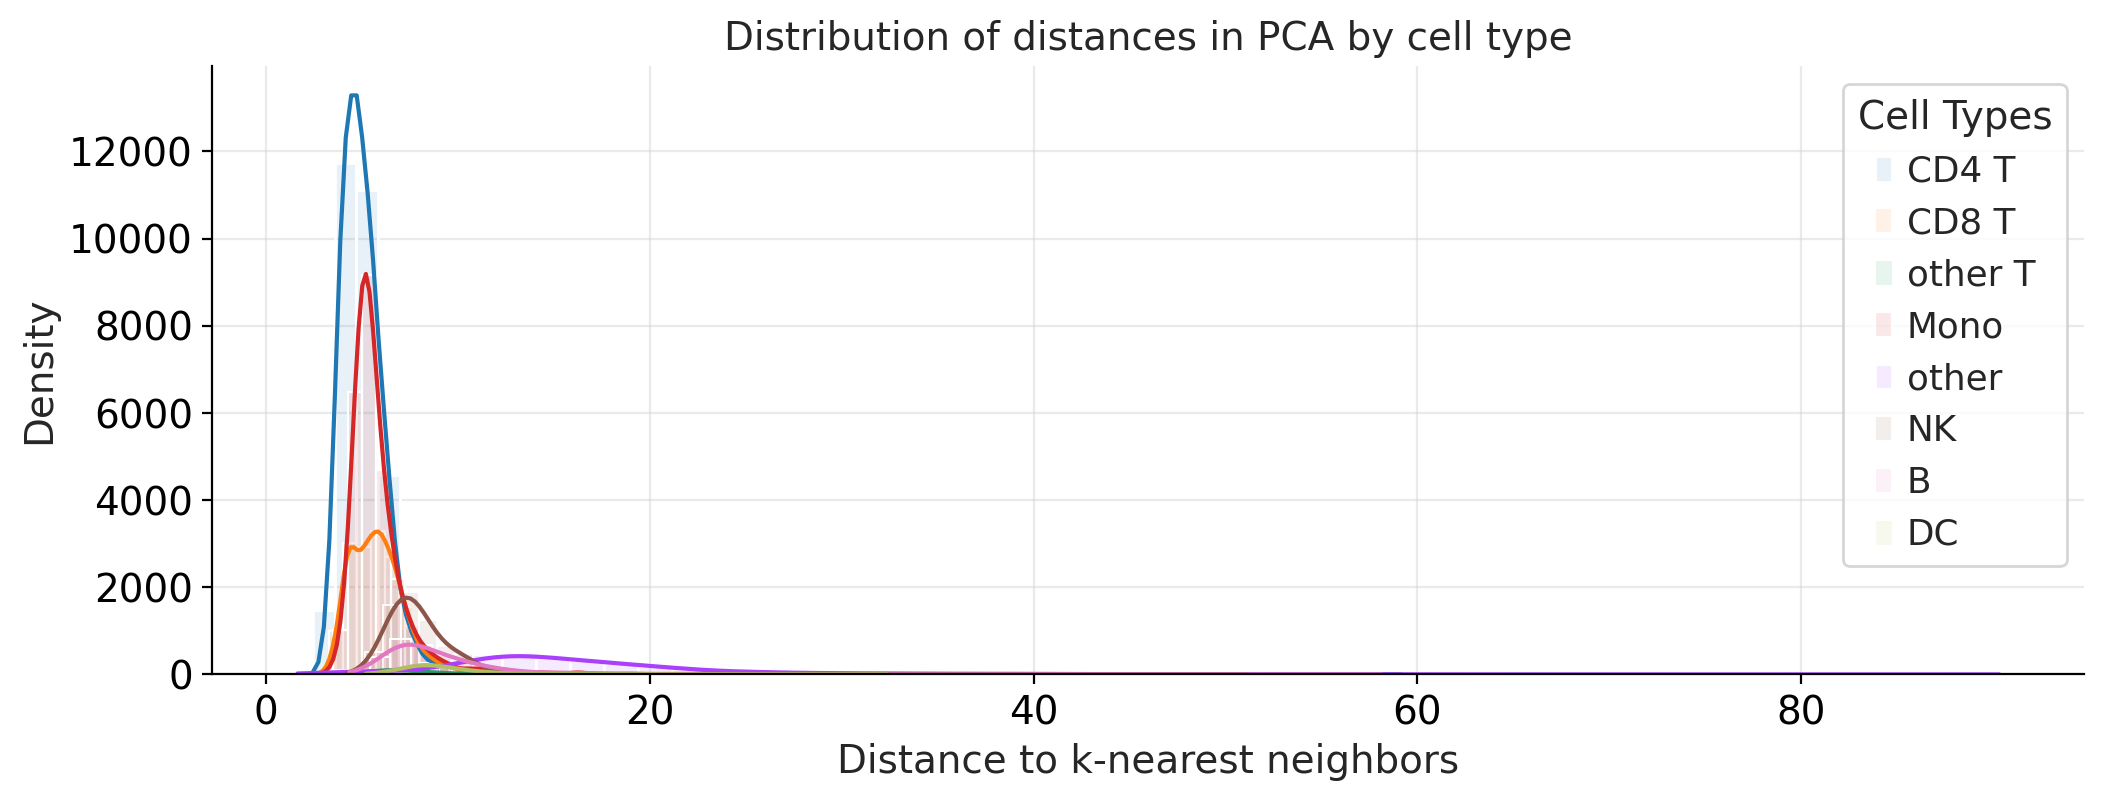

In [76]:
# Доступ к матрице расстояний и клеточным типам
distances_pca = adata_P1_pca.obsp["distances"]
cell_types = adata_P1_pca.obs['celltype.l1'].unique()

# Визуализация распределений расстояний для PCA-эмбеддинга
plt.figure(figsize=(12, 4))
for cell_type in cell_types:
    # Маска для отбора клеток данного типа
    cell_mask = adata_P1_pca.obs['celltype.l1'] == cell_type
    # Извлечение расстояний для клеток данного типа
    cell_distances = distances_pca[cell_mask].data

    sns.histplot(cell_distances, label=cell_type, kde=True, bins=50, alpha=0.1)

# Настройки графика
plt.legend(title="Cell Types")
plt.xlabel("Distance to k-nearest neighbors")
plt.ylabel("Density")
plt.title("Distribution of distances in PCA by cell type")
plt.grid(alpha=0.4)
plt.show()

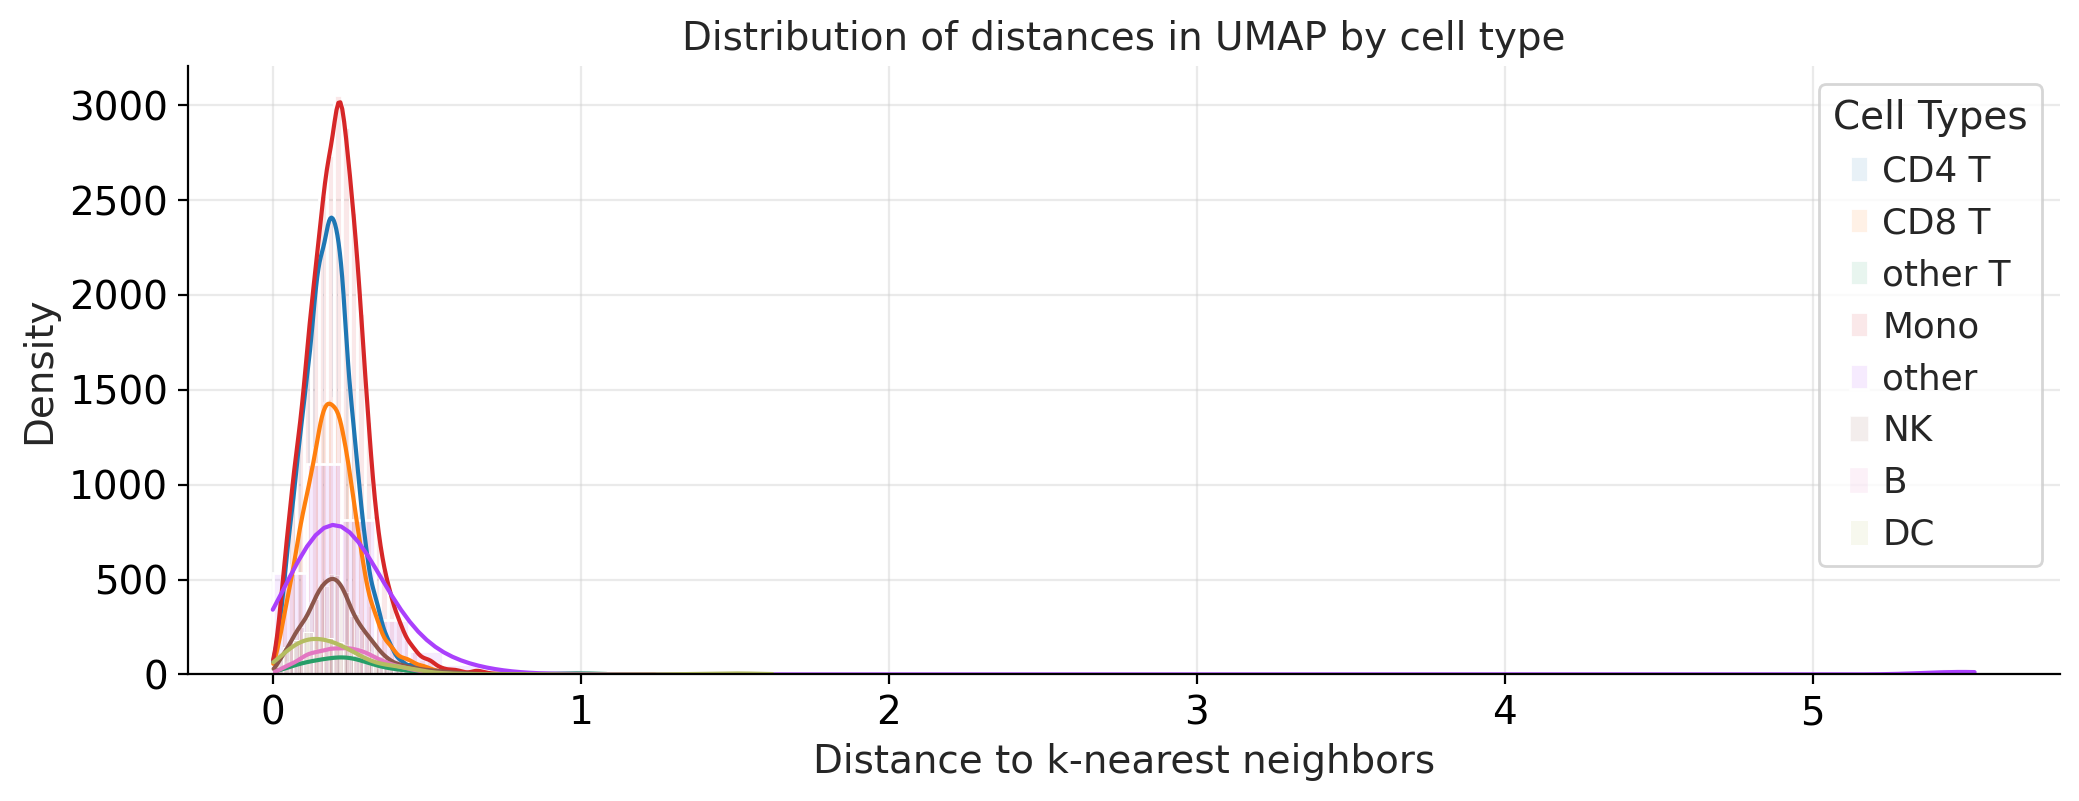

In [77]:
# Доступ к матрице расстояний и клеточным типам
distances_umap = adata_P1_umap.obsp["distances"]
cell_types = adata_P1_umap.obs['celltype.l1'].unique()

# Визуализация распределений расстояний для UMAP-эмбеддинга
plt.figure(figsize=(12, 4))
for cell_type in cell_types:
    # Маска для отбора клеток данного типа
    cell_mask = adata_P1_umap.obs['celltype.l1'] == cell_type
    # Извлечение расстояний для клеток данного типа
    cell_distances = distances_umap[cell_mask].data

    sns.histplot(cell_distances, label=cell_type, kde=True, bins=50, alpha=0.1)

# Настройки графика
plt.legend(title="Cell Types")
plt.xlabel("Distance to k-nearest neighbors")
plt.ylabel("Density")
plt.title("Distribution of distances in UMAP by cell type")
plt.grid(alpha=0.4)
plt.show()

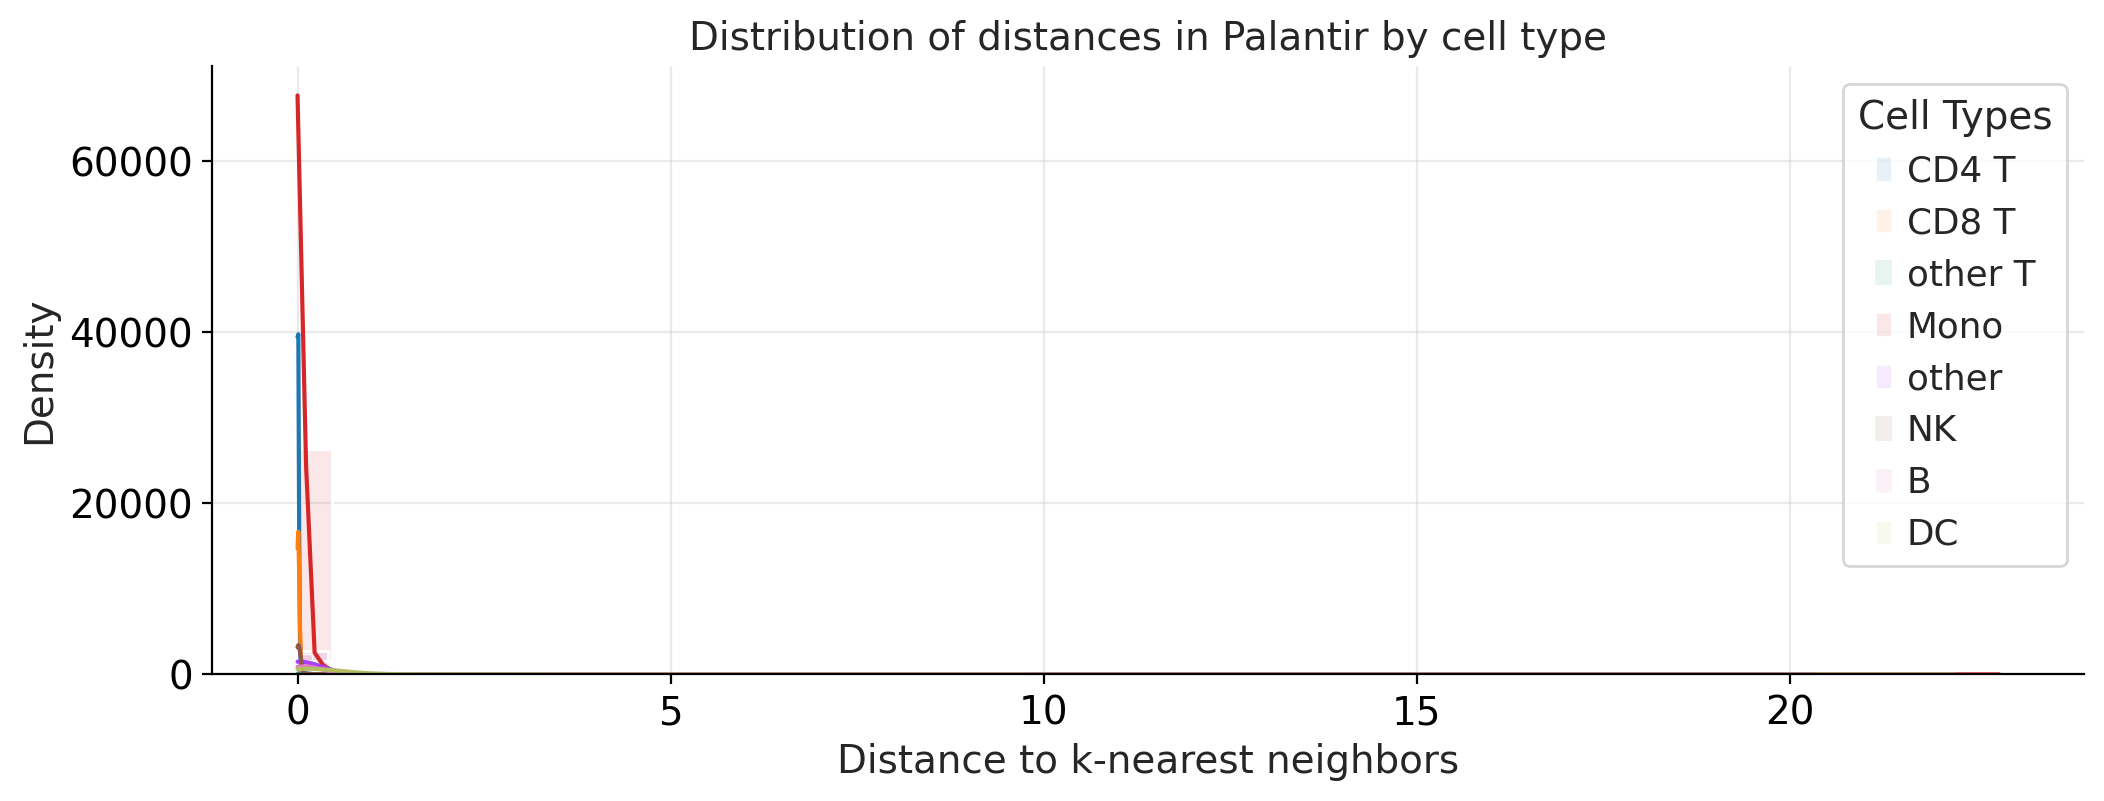

In [78]:
# Доступ к матрице расстояний и клеточным типам
distances_palantir = adata_P1_palantir.obsp["distances"]
cell_types = adata_P1_palantir.obs['celltype.l1'].unique()

# Визуализация распределений расстояний для Palantir-эмбеддинга
plt.figure(figsize=(12, 4))
for cell_type in cell_types:
    # Маска для отбора клеток данного типа
    cell_mask = adata_P1_palantir.obs['celltype.l1'] == cell_type
    # Извлечение расстояний для клеток данного типа
    cell_distances = distances_palantir[cell_mask].data

    sns.histplot(cell_distances, label=cell_type, kde=True, bins=50, alpha=0.1)

# Настройки графика
plt.legend(title="Cell Types")
plt.xlabel("Distance to k-nearest neighbors")
plt.ylabel("Density")
plt.title("Distribution of distances in Palantir by cell type")
plt.grid(alpha=0.4)
plt.show()

# kNN-расстояния между клеточными типами

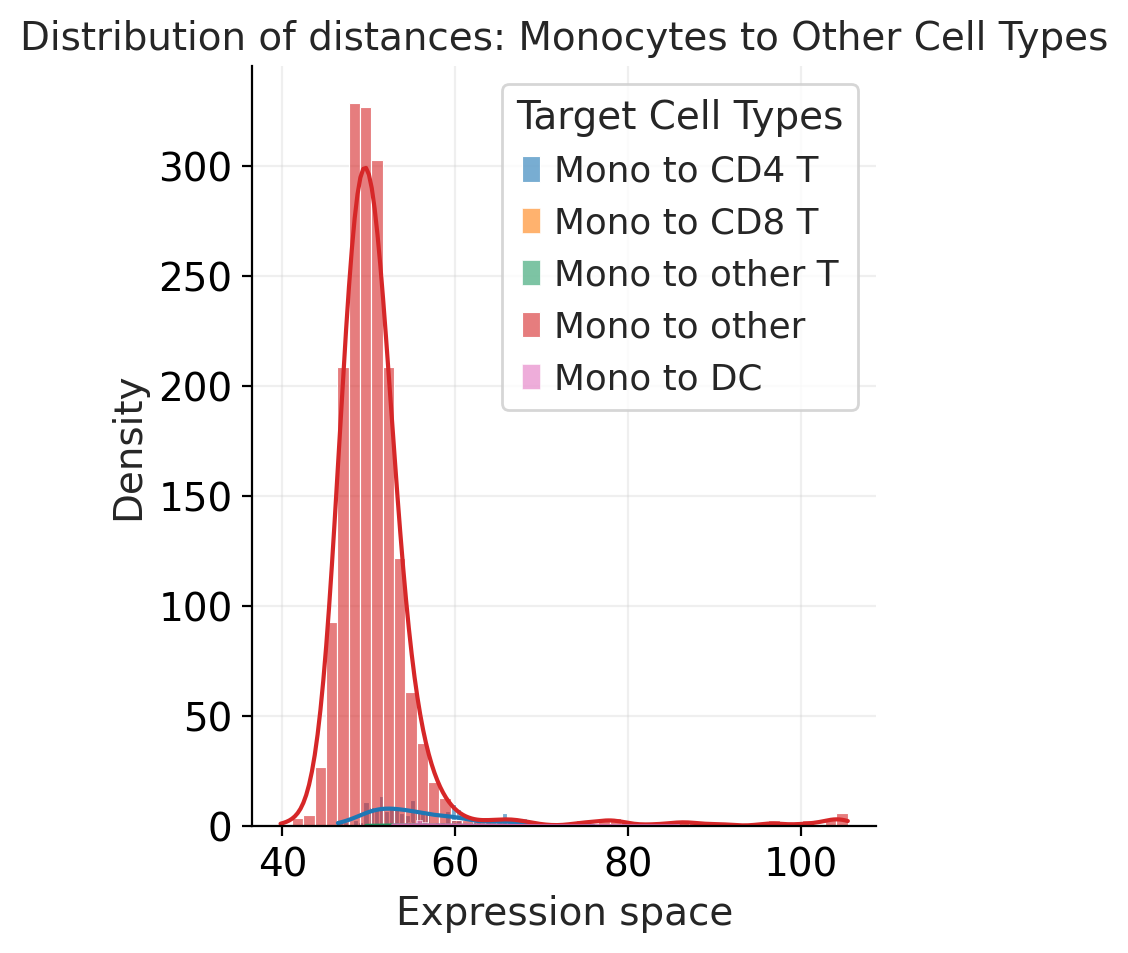

In [70]:
# Доступ к матрице расстояний и меткам клеток
distances = adata_P1.obsp["distances"]  # Матрица расстояний
cell_types = adata_P1.obs['celltype.l1']  # Метки клеток

# Маска для моноцитов
monocyte_mask = cell_types == "Mono"

# Индексы клеток, соответствующих моноцитам
monocyte_indices = np.where(monocyte_mask)[0]

# Уникальные типы клеток (кроме моноцитов)
non_monocyte_types = cell_types[cell_types != "Mono"].unique()

# Визуализация распределений расстояний для пар "моноцит - клеточный тип"
plt.figure(figsize=(4, 5))

for cell_type in non_monocyte_types:
    # Маска для клеток текущего типа
    target_mask = cell_types == cell_type
    target_indices = np.where(target_mask)[0]

    # Распределение межкластерных расстояний для пары "моноциты - клетки типа X"
    intercluster_distances = []

    for mono_idx in monocyte_indices:
        # Ненулевые значения расстояний для текущего моноцита
        row_data = distances[mono_idx].toarray().flatten()
        nonzero_indices = np.nonzero(row_data)[0]

        # Фильтрация соседей: только клетки текущего типа
        for neighbor_idx in nonzero_indices:
            if neighbor_idx in target_indices:  # Если сосед относится к текущему типу
                intercluster_distances.append(row_data[neighbor_idx])

    # Преобразуем список в массив
    intercluster_distances = np.array(intercluster_distances)

    # Построение гистограммы для текущего типа клеток
    sns.histplot(intercluster_distances, label=f"Mono to {cell_type}", kde=True, bins=50, alpha=0.6)

# Настройки графика
plt.legend(title="Target Cell Types")
plt.xlabel("Expression space")
plt.ylabel("Density")
plt.title("Distribution of distances: Monocytes to Other Cell Types")
plt.grid(alpha=0.3)
plt.show()


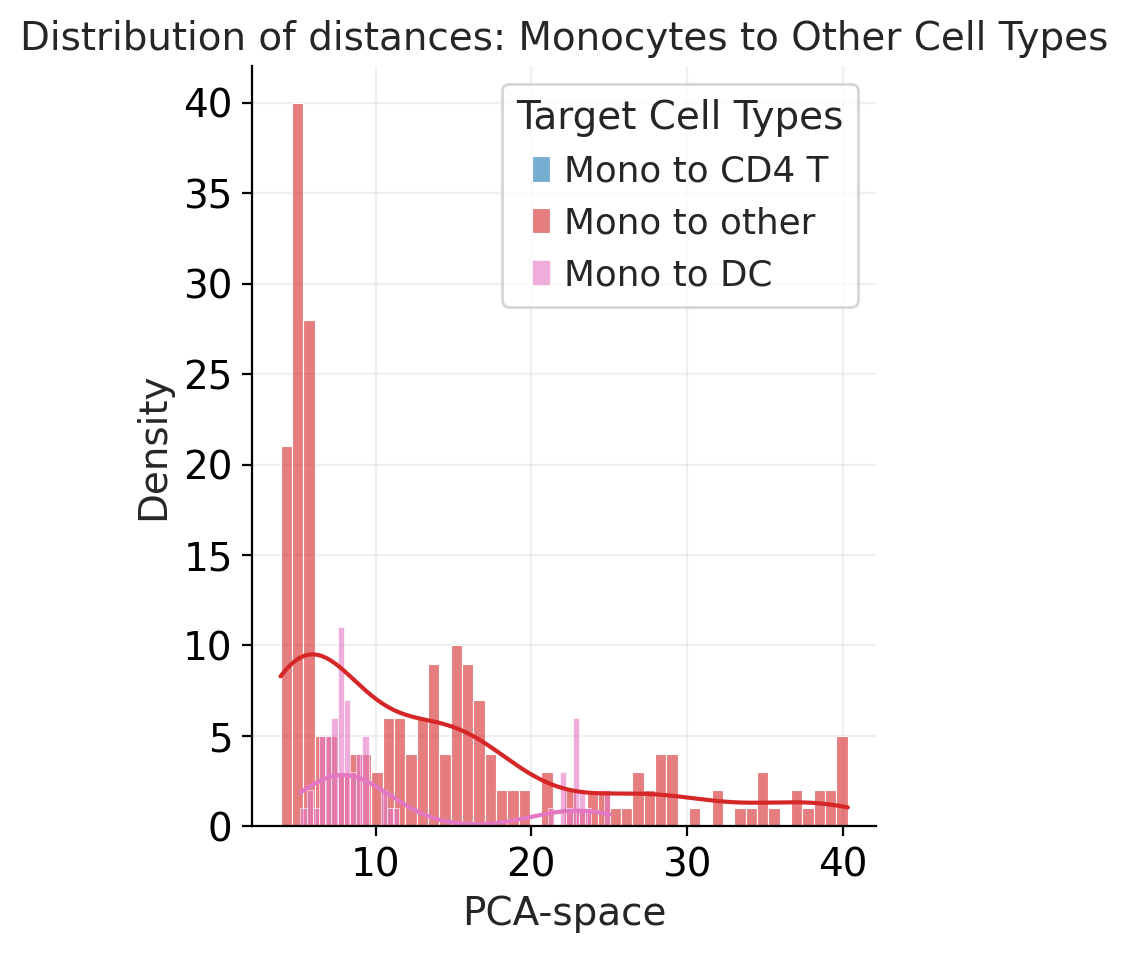

In [71]:
# Доступ к матрице расстояний и меткам клеток
distances = adata_P1_pca.obsp["distances"]  # Матрица расстояний
cell_types = adata_P1_pca.obs['celltype.l1']  # Метки клеток

# Маска для моноцитов
monocyte_mask = cell_types == "Mono"

# Индексы клеток, соответствующих моноцитам
monocyte_indices = np.where(monocyte_mask)[0]

# Уникальные типы клеток (кроме моноцитов)
non_monocyte_types = cell_types[cell_types != "Mono"].unique()

# Визуализация распределений расстояний для пар "моноцит - клеточный тип"
plt.figure(figsize=(4, 5))

for cell_type in non_monocyte_types:
    # Маска для клеток текущего типа
    target_mask = cell_types == cell_type
    target_indices = np.where(target_mask)[0]

    # Распределение межкластерных расстояний для пары "моноциты - клетки типа X"
    intercluster_distances = []

    for mono_idx in monocyte_indices:
        # Ненулевые значения расстояний для текущего моноцита
        row_data = distances[mono_idx].toarray().flatten()
        nonzero_indices = np.nonzero(row_data)[0]

        # Фильтрация соседей: только клетки текущего типа
        for neighbor_idx in nonzero_indices:
            if neighbor_idx in target_indices:  # Если сосед относится к текущему типу
                intercluster_distances.append(row_data[neighbor_idx])

    # Преобразуем список в массив
    intercluster_distances = np.array(intercluster_distances)

    # Построение гистограммы для текущего типа клеток
    sns.histplot(intercluster_distances, label=f"Mono to {cell_type}", kde=True, bins=50, alpha=0.6)

# Настройки графика
plt.legend(title="Target Cell Types")
plt.xlabel("PCA-space")
plt.ylabel("Density")
plt.title("Distribution of distances: Monocytes to Other Cell Types")
plt.grid(alpha=0.3)
plt.show()

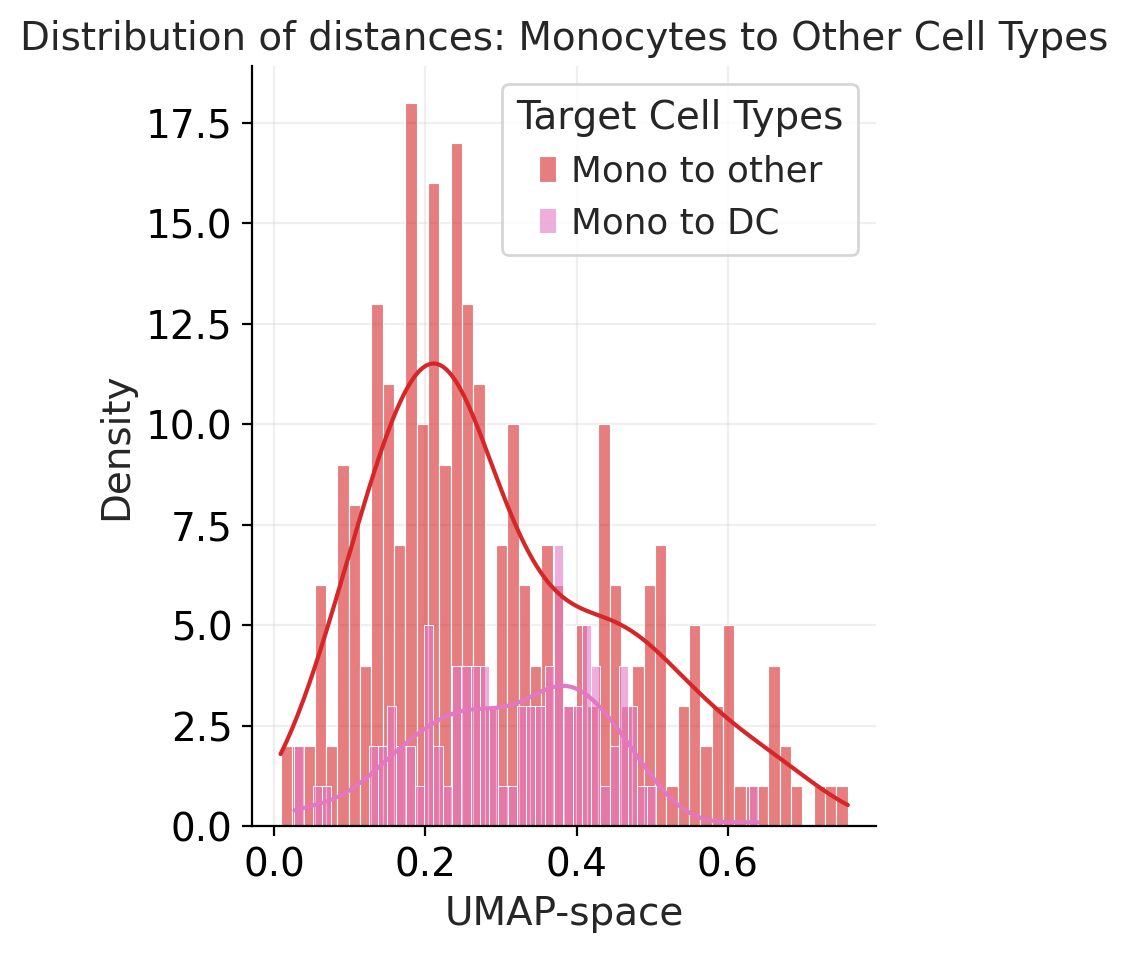

In [72]:
# Доступ к матрице расстояний и меткам клеток
distances = adata_P1_umap.obsp["distances"]  # Матрица расстояний
cell_types = adata_P1_umap.obs['celltype.l1']  # Метки клеток

# Маска для моноцитов
monocyte_mask = cell_types == "Mono"

# Индексы клеток, соответствующих моноцитам
monocyte_indices = np.where(monocyte_mask)[0]

# Уникальные типы клеток (кроме моноцитов)
non_monocyte_types = cell_types[cell_types != "Mono"].unique()

# Визуализация распределений расстояний для пар "моноцит - клеточный тип"
plt.figure(figsize=(4, 5))

for cell_type in non_monocyte_types:
    # Маска для клеток текущего типа
    target_mask = cell_types == cell_type
    target_indices = np.where(target_mask)[0]

    # Распределение межкластерных расстояний для пары "моноциты - клетки типа X"
    intercluster_distances = []

    for mono_idx in monocyte_indices:
        # Ненулевые значения расстояний для текущего моноцита
        row_data = distances[mono_idx].toarray().flatten()
        nonzero_indices = np.nonzero(row_data)[0]

        # Фильтрация соседей: только клетки текущего типа
        for neighbor_idx in nonzero_indices:
            if neighbor_idx in target_indices:  # Если сосед относится к текущему типу
                intercluster_distances.append(row_data[neighbor_idx])

    # Преобразуем список в массив
    intercluster_distances = np.array(intercluster_distances)

    # Построение гистограммы для текущего типа клеток
    sns.histplot(intercluster_distances, label=f"Mono to {cell_type}", kde=True, bins=50, alpha=0.6)

# Настройки графика
plt.legend(title="Target Cell Types")
plt.xlabel("UMAP-space")
plt.ylabel("Density")
plt.title("Distribution of distances: Monocytes to Other Cell Types")
plt.grid(alpha=0.3)
plt.show()

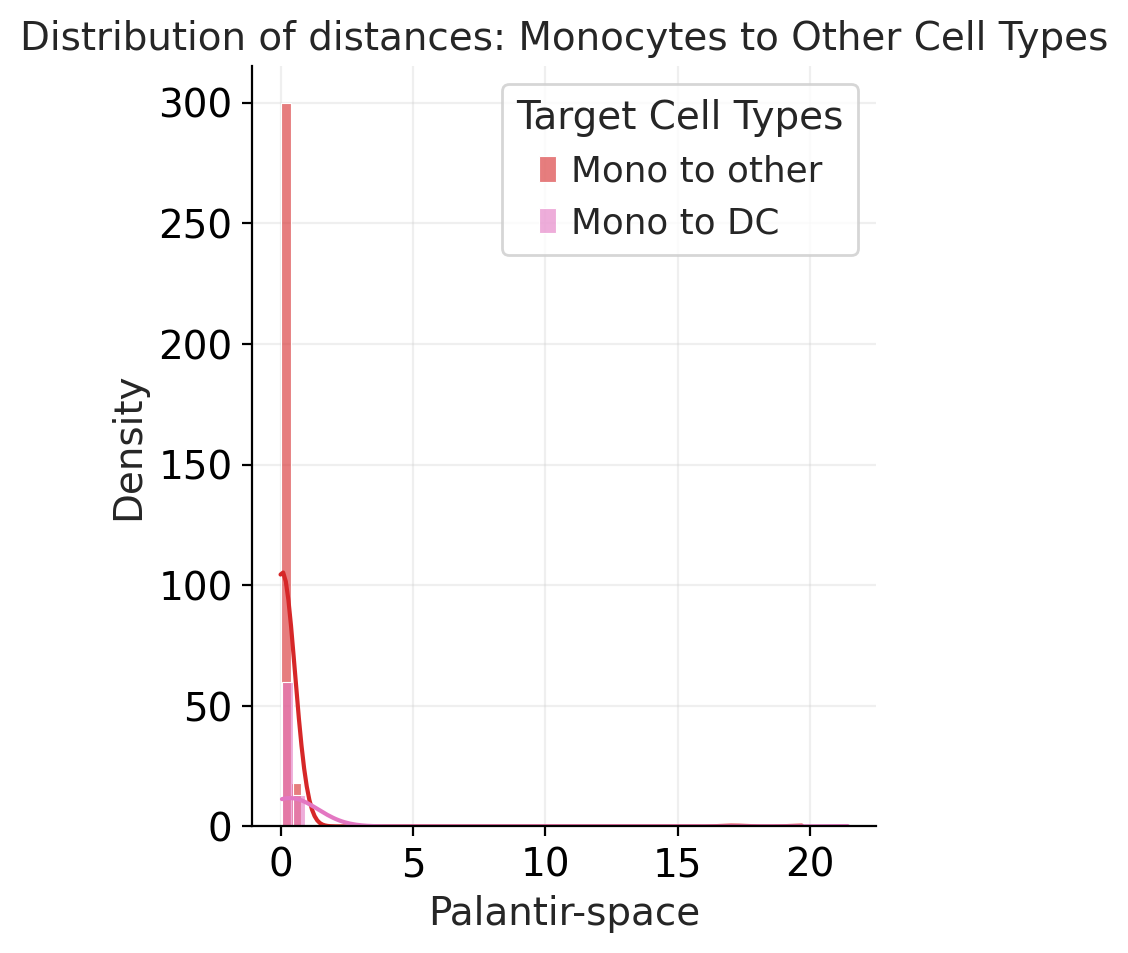

In [74]:
# Доступ к матрице расстояний и меткам клеток
distances = adata_P1_palantir.obsp["distances"]  # Матрица расстояний
cell_types = adata_P1_palantir.obs['celltype.l1']  # Метки клеток

# Маска для моноцитов
monocyte_mask = cell_types == "Mono"

# Индексы клеток, соответствующих моноцитам
monocyte_indices = np.where(monocyte_mask)[0]

# Уникальные типы клеток (кроме моноцитов)
non_monocyte_types = cell_types[cell_types != "Mono"].unique()

# Визуализация распределений расстояний для пар "моноцит - клеточный тип"
plt.figure(figsize=(4, 5))

for cell_type in non_monocyte_types:
    # Маска для клеток текущего типа
    target_mask = cell_types == cell_type
    target_indices = np.where(target_mask)[0]

    # Распределение межкластерных расстояний для пары "моноциты - клетки типа X"
    intercluster_distances = []

    for mono_idx in monocyte_indices:
        # Ненулевые значения расстояний для текущего моноцита
        row_data = distances[mono_idx].toarray().flatten()
        nonzero_indices = np.nonzero(row_data)[0]

        # Фильтрация соседей: только клетки текущего типа
        for neighbor_idx in nonzero_indices:
            if neighbor_idx in target_indices:  # Если сосед относится к текущему типу
                intercluster_distances.append(row_data[neighbor_idx])

    # Преобразуем список в массив
    intercluster_distances = np.array(intercluster_distances)

    # Построение гистограммы для текущего типа клеток
    sns.histplot(intercluster_distances, label=f"Mono to {cell_type}", kde=True, bins=50, alpha=0.6)

# Настройки графика
plt.legend(title="Target Cell Types")
plt.xlabel("Palantir-space")
plt.ylabel("Density")
plt.title("Distribution of distances: Monocytes to Other Cell Types")
plt.grid(alpha=0.3)
plt.show()

In [60]:
print(adata_P1.obs.loc[adata_P1.obs['celltype.l1'] == 'mono', 'celltype.l2'].unique())

[], Categories (31, object): ['ASDC', 'B intermediate', 'B memory', 'B naive', ..., 'cDC2', 'dnT',
                          'gdT', 'pDC']
